In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gzip

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

plt.style.use('themes/rose-pine-moon.mplstyle')


%config InlineBackend.figure_format='svg'

In [2]:
# Load the data
data = pd.read_feather('data/temp/data.feather')

In [3]:
print(len(data))
data.head()


1821316


,date,primaryTime,emulated,name,releaseDate,name_category,name_user,location,platform_name
8,2021-12-22,449.533,False,RE:RUN,2020-08-08,Any%,quebecpower,ca/qc,PC
9,2019-02-09,194.000,False,Time Warpers,2018-11-02,Zones 1-100,_zuR,br,PC
11,2014-11-17,857.000,True,Kirby's Dream Land,1992-04-27,Normal Mode,SapphireYoshi,us,Game Boy
12,2014-11-17,3062.000,False,Kirby: Nightmare in Dream Land,2002-10-25,Any%,SapphireYoshi,us,Game Boy Advance
13,2014-11-17,2454.000,False,Kirby & The Amazing Mirror,2004-04-15,Any%,SapphireYoshi,us,Game Boy Advance


In [4]:
# Find the games ("name") with the most submissions, and keep the top 100, along with their release date and platform
top_games = data[["name", "name_category"]].value_counts()


# Convert the index to columns
top_games = top_games.reset_index()

# For each game, find the first release date and platform
top_games_data = data[data["name"].isin(top_games["name"])].groupby(["name", "name_category"]).agg(
    {"releaseDate": "first", "platform_name": "first"}
)


# Add count of submissions for each game and category in the top games
top_games_data = top_games_data.join(data[["name", "name_category"]].value_counts(), on=["name", "name_category"])


# Add sum of all submissions for each game in the top games
top_games_data["sum_count"] = top_games_data["count"].groupby("name").transform("sum")

# Sort by count of submissions (descending)
top_games_data = top_games_data.sort_values(["sum_count", "count"], ascending=False)

# Remove any rown that have NaN or None
top_games_data = top_games_data.dropna()

# Reset the index
top_games_data = top_games_data.reset_index()

# Keep the 100 unique games (name) with the most submissions, disregarding the category
top_games_data_names = top_games_data.drop_duplicates(subset=["name"]).head(20)

# Only keep the games that are in the top 100 games with the most submissions
top_games_data = top_games_data[top_games_data["name"].isin(top_games_data_names["name"])]

# Fill NaN values with 0
top_games_data = top_games_data.fillna(0)

top_games_data

,name,name_category,releaseDate,platform_name,count,sum_count
0,Super Mario 64,16 Star,1996-06-23,Nintendo 64,17485,34823
1,Super Mario 64,70 Star,1996-06-23,Nintendo 64,9610,34823
2,Super Mario 64,120 Star,1996-06-23,Nintendo 64,4767,34823
3,Super Mario 64,1 Star,1996-06-23,Nintendo 64,2248,34823
4,Super Mario 64,0 Star,1996-06-23,Nintendo 64,713,34823
...,...,...,...,...,...,...
197,Resident Evil 2 (2019),New Game (Console),2019-01-25,PlayStation 4,1877,6866
198,Resident Evil 2 (2019),New Game + (Console),2019-01-25,PlayStation 4,1040,6866
199,Resident Evil 2 (2019),New Game + (PC),2019-01-25,PC,815,6866
200,Resident Evil 2 (2019),Any% (PC),2019-01-25,PC,88,6866


In [5]:
# Only keep the data for the top 100 games
data_top_100 = data[data["name"].isin(top_games_data["name"])]

# Drop platform_name for this analysis
data_top_100 = data_top_100.drop(columns=["platform_name"])

data_top_100

,date,primaryTime,emulated,name,releaseDate,name_category,name_user,location
47,2020-08-02,1170.320,False,Portal,2007-10-09,Inbounds No SLA,TobanCZ,cz
429,2020-03-31,47.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
430,2021-01-05,39.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
431,2021-01-05,46.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
432,2021-01-05,86.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
...,...,...,...,...,...,...,...,...
3995581,2021-05-26,256.556,False,Pou,2012-08-16,Survive,Yuzuru_ARG,ar
3995669,2016-08-09,303.000,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se
3995670,2016-08-05,307.000,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se
3995671,2016-08-24,302.269,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se


In [6]:
# Convert column date to datetime
data_top_100["date"] = pd.to_datetime(data_top_100["date"])

data_top_100

,date,primaryTime,emulated,name,releaseDate,name_category,name_user,location
47,2020-08-02,1170.320,False,Portal,2007-10-09,Inbounds No SLA,TobanCZ,cz
429,2020-03-31,47.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
430,2021-01-05,39.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
431,2021-01-05,46.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
432,2021-01-05,86.000,False,Seterra (Old Version),1997-01-01,The U.S.: 50 States,cheavus,us
...,...,...,...,...,...,...,...,...
3995581,2021-05-26,256.556,False,Pou,2012-08-16,Survive,Yuzuru_ARG,ar
3995669,2016-08-09,303.000,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se
3995670,2016-08-05,307.000,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se
3995671,2016-08-24,302.269,True,Super Mario Bros.,1985-09-13,Any%,SkylightFox,se


In [7]:
# For each month in the date range of the data, find the number of submissions for each game
data_top_100_monthly = data_top_100.groupby(["name", pd.Grouper(key="date", freq="M")]).size().unstack(fill_value=0)

# Sort column names (dates) in ascending order
data_top_100_monthly = data_top_100_monthly.sort_index(axis=1)

# Revert column and index
data_top_100_monthly = data_top_100_monthly.T

In [8]:
data_top_100_monthly

name,Celeste,Getting Over It With Bennett Foddy,Mario Kart 8 Deluxe,Minecraft: Java Edition,Minecraft: Java Edition Category Extensions,Portal,Pou,ROBLOX: Speed Run 4,Resident Evil 2 (2019),Seterra (Old Version),SpongeBob SquarePants: Battle for Bikini Bottom,Super Mario 64,Super Mario 64 Category Extensions,Super Mario Bros.,Super Mario Odyssey,Super Mario Sunshine,Super Mario World,Super Metroid,The Legend of Zelda: A Link to the Past,The Legend of Zelda: Ocarina of Time
date,,,,,,,,,,,,,,,,,,,,
2004-04-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2004-11-30,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2005-05-31,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2005-06-30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2005-08-31,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,205,260,231,42,4,167,260,195,32,0,30,755,89,133,169,69,68,73,27,38
2023-08-31,243,165,241,31,0,106,118,107,25,0,30,392,81,97,175,56,70,113,39,58
2023-09-30,131,113,188,10,0,73,56,9,28,0,14,239,67,68,158,54,88,73,20,20


In [9]:
# Only keep indices above 2012
data_top_100_monthly = data_top_100_monthly[data_top_100_monthly.index >= '2012-01-01']

In [10]:
data_top_100_monthly

name,Celeste,Getting Over It With Bennett Foddy,Mario Kart 8 Deluxe,Minecraft: Java Edition,Minecraft: Java Edition Category Extensions,Portal,Pou,ROBLOX: Speed Run 4,Resident Evil 2 (2019),Seterra (Old Version),SpongeBob SquarePants: Battle for Bikini Bottom,Super Mario 64,Super Mario 64 Category Extensions,Super Mario Bros.,Super Mario Odyssey,Super Mario Sunshine,Super Mario World,Super Metroid,The Legend of Zelda: A Link to the Past,The Legend of Zelda: Ocarina of Time
date,,,,,,,,,,,,,,,,,,,,
2012-01-31,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,2,0,0
2012-02-29,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
2012-03-31,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2,0,0,13
2012-04-30,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,13
2012-05-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,205,260,231,42,4,167,260,195,32,0,30,755,89,133,169,69,68,73,27,38
2023-08-31,243,165,241,31,0,106,118,107,25,0,30,392,81,97,175,56,70,113,39,58
2023-09-30,131,113,188,10,0,73,56,9,28,0,14,239,67,68,158,54,88,73,20,20


In [18]:
# Export data_top_100_monthly as a list of list containing date, count, and name
data_top_100_monthly_list = []
data_names = data_top_100_monthly.columns
for name in data_names:
    for date, count in data_top_100_monthly[name].items():
        # Convert date to string
        date = date.strftime("%Y-%m")
        data_top_100_monthly_list.append([date, count, name])
        
final_data = {'games': data_top_100_monthly.columns.to_list(), 'data': data_top_100_monthly_list}

In [20]:
# Eport to json file
# Save the graph data as a json file
with open("/Users/cdroin/Library/CloudStorage/GoogleDrive-colasdroin@gmail.com/Mon Drive/Data_viz/speedruns/app/public/data/popularity_data.json", "w") as f:
    json.dump(final_data, f)

# Save the graph data as a json file
with gzip.open("/Users/cdroin/Library/CloudStorage/GoogleDrive-colasdroin@gmail.com/Mon Drive/Data_viz/speedruns/app/public/data/popularity_data.json.gz", "wt") as f:
    json.dump(final_data, f)

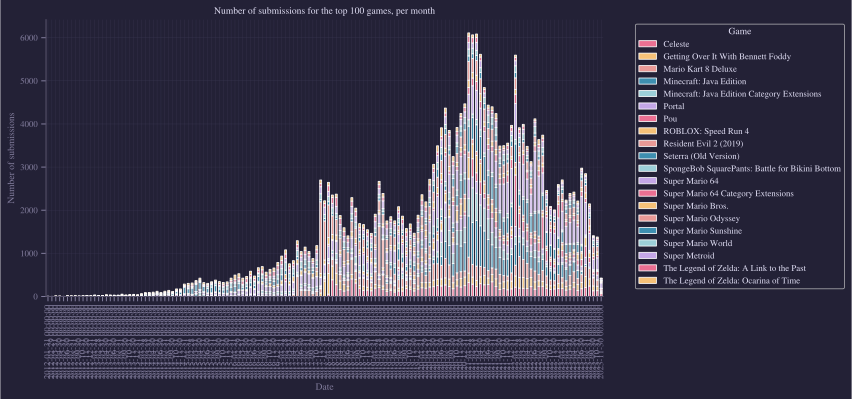

In [11]:
# Do a stacked bar plot of the number of submissions for each game, for each month
fig, ax = plt.subplots(figsize=(10, 5))

data_top_100_monthly.plot(kind="bar", stacked=True, ax=ax)

plt.legend(title="Game", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Date")
plt.ylabel("Number of submissions")
plt.title("Number of submissions for the top 100 games, per month")

plt.show()